In [1]:
!pip install tensorflow-io

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 14.6 MB/s eta 0:00:00


In [2]:
import os
import pathlib
import numpy as np
import seaborn as sns
import tensorflow as tf
from IPython import display
import tensorflow_io as tfio
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Normalization, Input, Resizing, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, LSTM, TimeDistributed, BatchNormalization

# Carga

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ruta principal de los datos
DATASET_PATH = "/content/drive/MyDrive/datasets_tensorflow/dataset_reducido"

In [ ]:
data_dir = pathlib.Path(DATASET_PATH)

In [ ]:
data_dir

PosixPath('/content/drive/MyDrive/Estudios/FCEIA/5to Cuatrimestre/Aprendizaje Automático 2 - AA2/Trabajo Practico 2/dataset_reducido')

In [ ]:
import soundfile as sf

# Leer la información del archivo de audio
info = sf.info('/content/drive/MyDrive/Estudios/FCEIA/5to Cuatrimestre/Aprendizaje Automático 2 - AA2/Trabajo Practico 2/dataset_reducido/español/1001744349579669536.wav')

print(f"Frecuencia de muestreo: {info.samplerate} Hz ({info.samplerate / 1000:.1f} kHz)")

Frecuencia de muestreo: 16000 Hz (16.0 kHz)


In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=16,
    validation_split=0.3,
    seed=0,
    output_sequence_length=160000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 800 files belonging to 4 classes.
Using 560 files for training.
Using 240 files for validation.

label names: ['español' 'frances' 'ingles' 'japones']


In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 160000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(16, 160000)
(16,)


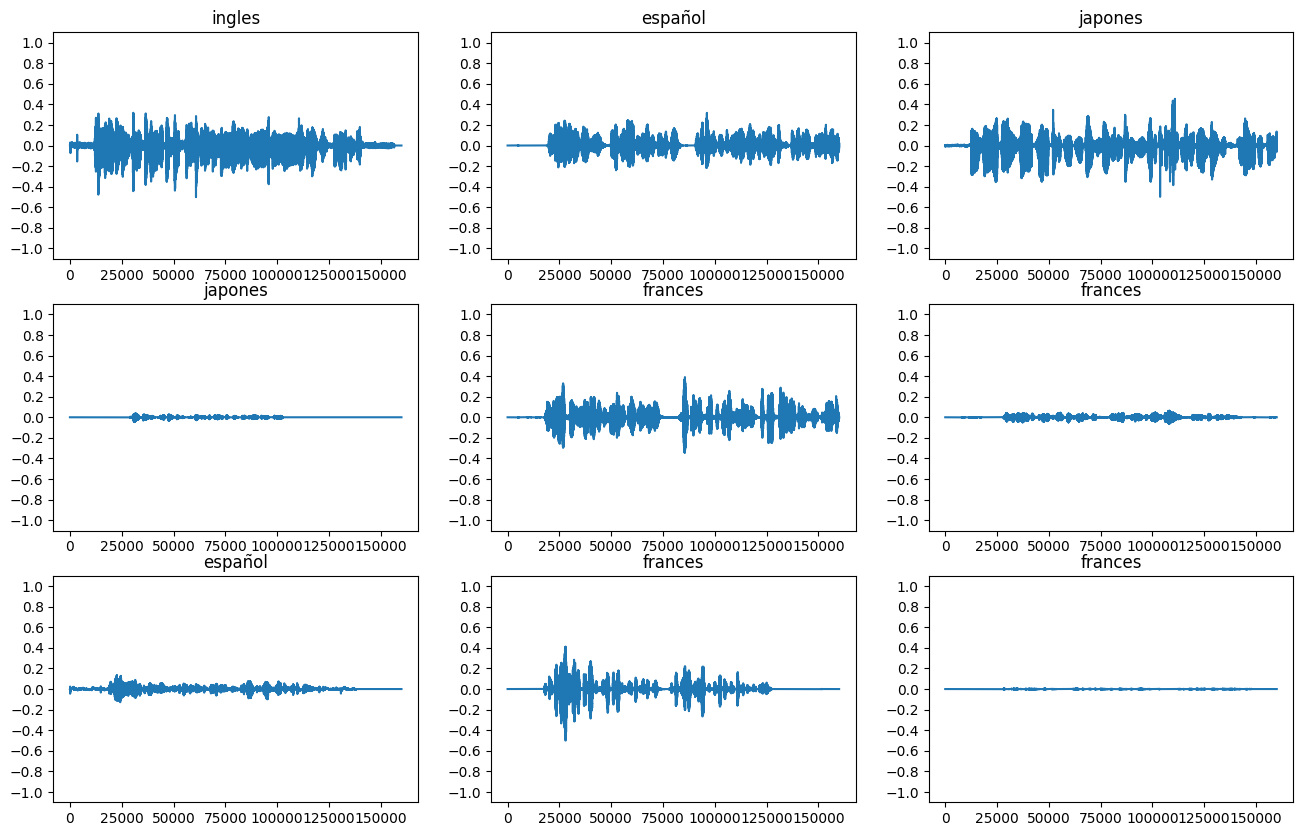

In [ ]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: ingles
Waveform shape: (160000,)
Spectrogram shape: (1249, 129, 1)
Audio playback


Label: español
Waveform shape: (160000,)
Spectrogram shape: (1249, 129, 1)
Audio playback


Label: japones
Waveform shape: (160000,)
Spectrogram shape: (1249, 129, 1)
Audio playback


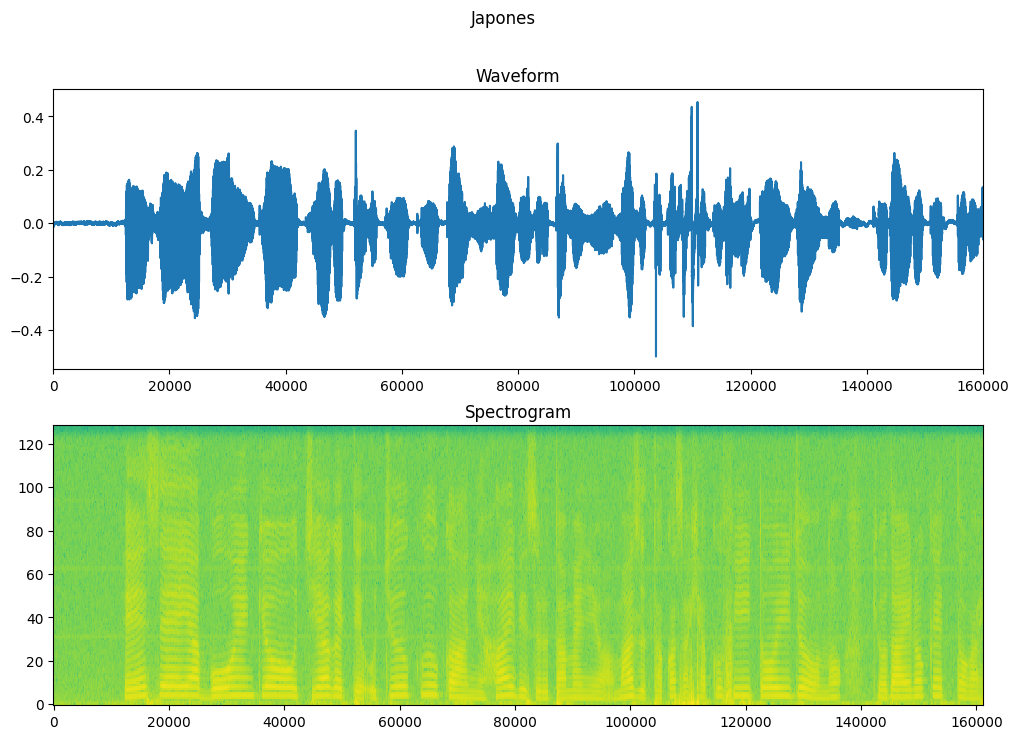

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 160000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

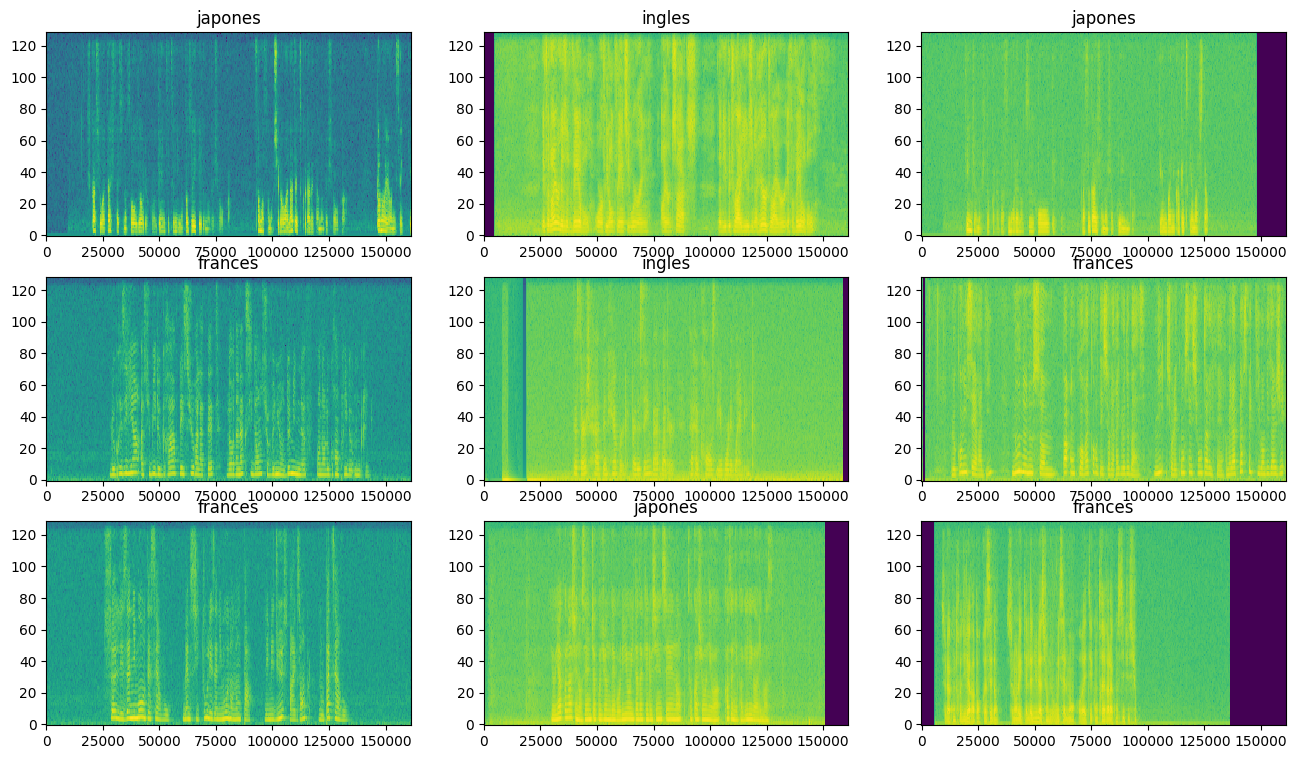

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

# CNN

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

Input shape: (1249, 129, 1)


In [ ]:
norm_layer = Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

In [ ]:
# Directorio para guardar checkpoints
checkpoint_dir = './spect_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
os.makedirs(checkpoint_dir, exist_ok=True)  # Crear el directorio si no existe

# Callback para guardar checkpoints
checkpoint_callback = ModelCheckpoint(
    filepath="./spect_training_checkpoints/ckpt_{epoch}.keras",  # Agrega la extensión .keras
    save_weights_only=False,  # Guarda todo el modelo, no solo los pesos
    monitor='val_loss',  # Métrica a monitorear
    save_best_only=True,  # Guarda solo el mejor modelo
    mode='min'  # Elige 'min' para métricas como 'loss'
)


# Callback para detener el entrenamiento temprano
early_stopping_callback = EarlyStopping(
    monitor='loss',          # Monitorea la pérdida
    patience=30,              # Número de épocas sin mejora antes de detener
    restore_best_weights=True  # Restaura los pesos del mejor modelo
)

In [ ]:
model = Sequential([
    Input(shape=input_shape),
    # # Downsample the input.
    # Resizing(212, 129),
    # Normalize.
    norm_layer,

    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((8, 1)),

    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),

    Dropout(0.6),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(4, activation='softmax'),
])

model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_4 (Normalization)      │ (None, 1249, 129, 1)        │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_78 (Conv2D)                   │ (None, 1247, 127, 32)       │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_79 (Conv2D)                   │ (None, 1245, 125, 32)       │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (None, 155, 125, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_80 (Conv2D)                   │ (None, 153, 123, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_81 (Conv2D)                   │ (None, 151, 121, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_50 (MaxPooling2D)      │ (None, 75, 60, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_82 (Conv2D)                   │ (None, 73, 58, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_51 (MaxPooling2D)      │ (None, 36, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_83 (Conv2D)                   │ (None, 34, 27, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_52 (MaxPooling2D)      │ (None, 17, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_84 (Conv2D)                   │ (None, 15, 11, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_53 (MaxPooling2D)      │ (None, 7, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 7, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 2240)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 32)                  │          71,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 247,623 (967.28 KB)

 Trainable params: 247,620 (967.27 KB)

 Non-trainable params: 3 (16.00 B)

In [ ]:
model.compile(
    optimizer=Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 100
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_callback]
)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 0.2882 - loss: 1.3746 - val_accuracy: 0.3583 - val_loss: 1.2998
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.3310 - loss: 1.3445 - val_accuracy: 0.3458 - val_loss: 1.3040
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.4218 - loss: 1.2734 - val_accuracy: 0.5000 - val_loss: 1.1437
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.5573 - loss: 1.1261 - val_accuracy: 0.5333 - val_loss: 1.1427
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.5735 - loss: 1.0611 - val_accuracy: 0.5250 - val_loss: 1.0149
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.6108 - loss: 0.9085 - val_accuracy: 0.6125 - val_loss: 0.9284
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.6798 - loss: 0.7892 - val_accuracy: 0.6375 - val_loss: 0.9400
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.6753 - loss: 0.7382 - val_accu

In [ ]:
y_pey = model.predict(val_spectrogram_ds)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [ ]:
# Evaluar en el conjunto de prueba
test_loss, test_acc = model.evaluate(val_spectrogram_ds)
print(f"Accuracy en conjunto de prueba: {test_acc*100:.2f}%")

# Guardar el modelo entrenado
model.save('modelo_audio.keras')

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8271 - loss: 1.0810
Accuracy en conjunto de prueba: 82.50%


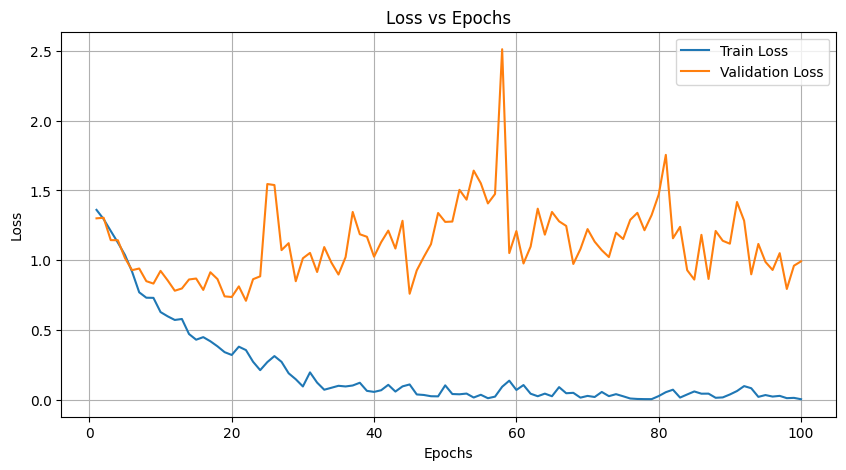

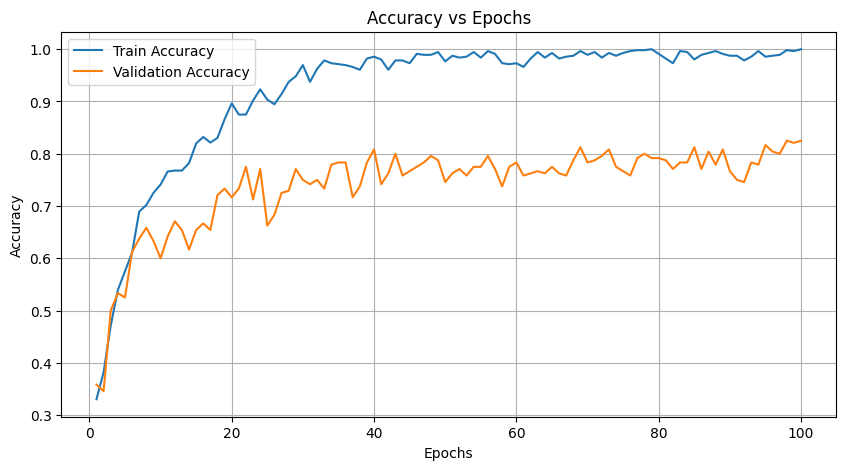

In [ ]:
import matplotlib.pyplot as plt

# Extraer datos del historial
history_data = history.history
epochs = range(1, len(history_data['loss']) + 1)

# Graficar Loss vs Epoch
plt.figure(figsize=(10, 5))
plt.plot(epochs, history_data['loss'], label='Train Loss')
plt.plot(epochs, history_data['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid()
plt.show()

# Graficar Accuracy vs Epoch
plt.figure(figsize=(10, 5))
plt.plot(epochs, history_data['accuracy'], label='Train Accuracy')
plt.plot(epochs, history_data['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display

# Seleccionar un batch del conjunto de validación
for audio_waveforms, labels in val_ds.take(1):  # Usar el conjunto de validación con audios originales
    audio_waveforms = audio_waveforms.numpy()
    labels = labels.numpy()
    break

# Realizar predicciones para todo el batch
predictions = model.predict(val_spectrogram_ds)

# Configurar el número de muestras a graficar
num_samples = min(5, len(audio_waveforms))  # Mostrar hasta 5 ejemplos

for i in range(num_samples):
    # Reproducir el audio
    label = label_names[labels[i]]
    print(f"Audio {i + 1}:")
    print(f"True Label: {label}")
    display(Audio(audio_waveforms[i], rate=16000))

    # Mostrar predicciones en gráfico de barras
    plt.figure(figsize=(8, 4))
    plt.bar(label_names, predictions[i])
    predicted_label = label_names[np.argmax(predictions[i])]
    plt.title(f'True: {label} | Predicted: {predicted_label}')
    plt.ylabel('Probability')
    plt.ylim([0, 1])
    plt.grid(True)
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

# RNN

In [5]:
drive.mount('/content/drive')
data_dir = "/content/drive/MyDrive/datasets_tensorflow/dataset_reducido"
classes = os.listdir(data_dir)
num_classes = len(classes)
print("Clases:", classes)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Clases: ['español', 'frances', 'japones', 'ingles']


In [6]:
# Parámetros para el procesamiento
sample_rate = 16000  # Frecuencia de muestreo estándar
segment_length = 128  # Número de frames en cada fragmento de espectrograma
segment_stride = 64  # Paso entre fragmentos (superposición)

In [7]:
def compute_spectrogram(audio_signal, sample_rate):
    spectrogram = tf.signal.stft(
        audio_signal,
        frame_length=512,
        frame_step=256,
        fft_length=512
    )
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)  # Añadir canal para Conv2D
    return spectrogram


In [8]:
def load_audio_classification_dataset(data_dir, sample_rate, segment_length, segment_stride):
    X, y = [], []
    for label, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for audio_name in os.listdir(class_dir):
            audio_path = os.path.join(class_dir, audio_name)
            # Cargar el archivo de audio
            audio_binary = tf.io.read_file(audio_path)
            audio, sr = tf.audio.decode_wav(audio_binary)
            audio = tf.squeeze(audio, axis=-1)  # Eliminar dimensión extra
            # Si la frecuencia de muestreo es diferente, ajustar
            if sr != sample_rate:
                audio = tfio.audio.resample(audio, rate_in=sr, rate_out=sample_rate)
            # Calcular el espectrograma
            spectrogram = compute_spectrogram(audio, sample_rate)
            spectrogram = spectrogram.numpy()
            # Dividir el espectrograma en fragmentos superpuestos
            num_segments = (spectrogram.shape[0] - segment_length) // segment_stride + 1
            for i in range(num_segments):
                start = i * segment_stride
                end = start + segment_length
                segment = spectrogram[start:end, :, :]
                if segment.shape[0] == segment_length:
                    X.append(segment)
                    y.append(label)
    X = np.array(X)
    y = to_categorical(y, num_classes)
    return X, y


In [9]:
# Cargar y preprocesar los datos
X, y = load_audio_classification_dataset(data_dir, sample_rate, segment_length, segment_stride)

# Mezclar los datos antes de dividirlos en entrenamiento y validación
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# Dividir los datos en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)

Forma de X_train: (5120, 128, 257, 1)
Forma de y_train: (5120, 4)


In [10]:
# Definir el modelo ajustado
model = Sequential()
# Capas convolucionales con kernel (3, 1)
model.add(TimeDistributed(Conv2D(32, (3, 1), activation='relu'), input_shape=(segment_length, X_train.shape[2], X_train.shape[3], 1)))
model.add(TimeDistributed(Conv2D(32, (3, 1), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 1))))
model.add(TimeDistributed(Conv2D(64, (3, 1), activation='relu')))
model.add(TimeDistributed(Conv2D(64, (3, 1), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 1))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.5))
# Capa recurrente
model.add(LSTM(64, return_sequences=False, dropout=0.5))
# Capas de salida
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Resumen del modelo
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 128, 255, 1, 32)     │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 128, 253, 1, 32)     │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 128, 126, 1, 32)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 128, 124, 1, 64)     │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 128, 122, 1, 64)     │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 128, 61, 1, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 128, 61, 1, 64)      │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 128, 3904)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 3904)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │       1,016,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,044,484 (3.98 MB)

 Trainable params: 1,044,356 (3.98 MB)

 Non-trainable params: 128 (512.00 B)

In [11]:
# Compilar el modelo
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_audio.keras', monitor='val_loss', save_best_only=True)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=16,
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 261s 615ms/step - accuracy: 0.2964 - loss: 1.3932 - val_accuracy: 0.3250 - val_loss: 1.3525
Epoch 2/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 189s 590ms/step - accuracy: 0.3619 - loss: 1.3294 - val_accuracy: 0.4898 - val_loss: 1.1778
Epoch 3/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 200s 584ms/step - accuracy: 0.4782 - loss: 1.1836 - val_accuracy: 0.5258 - val_loss: 1.1019
Epoch 4/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 204s 589ms/step - accuracy: 0.5388 - loss: 1.0833 - val_accuracy: 0.5648 - val_loss: 1.0086
Epoch 5/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 199s 581ms/step - accuracy: 0.5571 - loss: 1.0609 - val_accuracy: 0.5250 - val_loss: 1.0404
Epoch 6/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 205s 589ms/step - accuracy: 0.5807 - loss: 1.0019 - val_accuracy: 0.6102 - val_loss: 0.9408
Epoch 7/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 202s 590ms/step - accuracy: 0.5890 - loss: 0.9957 - val_accuracy: 0.5875 - val_loss: 0.9455
Epoch 8/100
320/320 ━━━━━━━━━━━━━━━━━━━━ 202s 591ms/step - accuracy: 

#### Si queremos cargar el mejor modelo hacemos esto:
```python
from tensorflow.keras.models import load_model

# Cargar el mejor modelo guardado
best_model = load_model('best_model_audio.keras')
```

## Visualización de la Precisión y Pérdida Durante el Entrenamiento

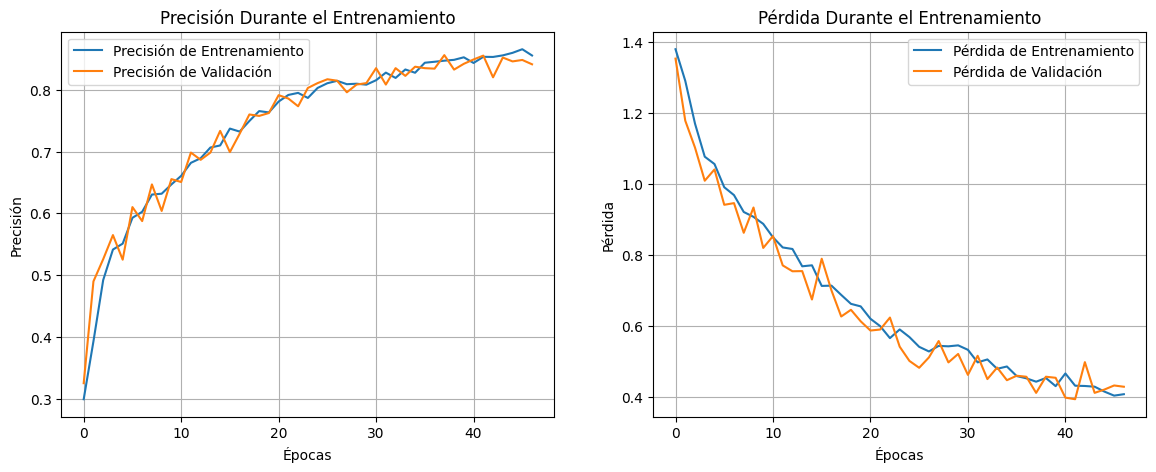

In [12]:
# Visualización de la precisión y pérdida durante el entrenamiento
plt.figure(figsize=(14, 5))

# Gráfico de Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Precisión Durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Gráfico de Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Pérdida Durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.show()

## Evaluación del Modelo en el Conjunto de Validación

In [13]:
# Evaluación del modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Precisión en Validación: {val_accuracy:.4f}")
print(f"Pérdida en Validación: {val_loss:.4f}")


40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.8656 - loss: 0.3837
Precisión en Validación: 0.8641
Pérdida en Validación: 0.3775


## Generar Informe de Clasificación y Matriz de Confusión

40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step
Informe de Clasificación:
               precision    recall  f1-score   support

    español       0.77      0.92      0.84       313
     frances       0.87      0.82      0.84       345
     japones       0.87      0.90      0.88       287
      ingles       0.89      0.76      0.82       335

    accuracy                           0.84      1280
   macro avg       0.85      0.85      0.85      1280
weighted avg       0.85      0.84      0.84      1280



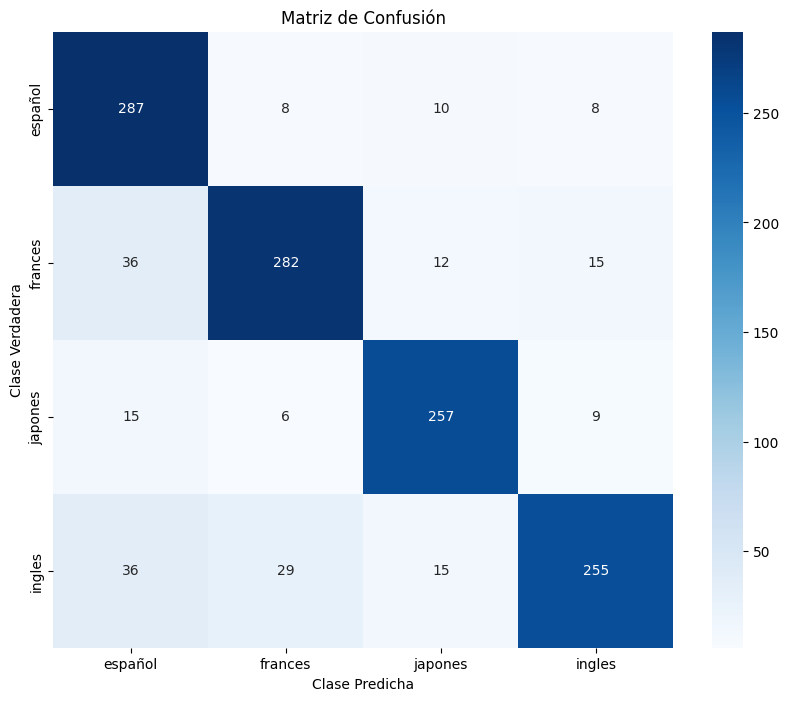

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Realizar predicciones en el conjunto de validación
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Generar el informe de clasificación
report = classification_report(y_true_classes, y_pred_classes, target_names=classes)
print("Informe de Clasificación:\n", report)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.show()


## Realizar Predicciones Sobre Nuevos Datos de Audio

In [15]:
def predict_audio(model, audio_path, sample_rate, segment_length, segment_stride):
    # Cargar el archivo de audio
    audio_binary = tf.io.read_file(audio_path)
    audio, sr = tf.audio.decode_wav(audio_binary)
    audio = tf.squeeze(audio, axis=-1)

    # Si la frecuencia de muestreo es diferente, ajustar
    if sr != sample_rate:
        audio = tfio.audio.resample(audio, rate_in=sr, rate_out=sample_rate)

    # Calcular el espectrograma
    spectrogram = compute_spectrogram(audio, sample_rate)
    spectrogram = spectrogram.numpy()

    # Normalizar el espectrograma (opcional pero recomendable)
    spectrogram = (spectrogram - np.mean(spectrogram)) / np.std(spectrogram)

    # Dividir el espectrograma en fragmentos
    num_segments = (spectrogram.shape[0] - segment_length) // segment_stride + 1
    segments = []
    for i in range(num_segments):
        start = i * segment_stride
        end = start + segment_length
        segment = spectrogram[start:end, :, :]
        if segment.shape[0] == segment_length:
            segments.append(segment)
    segments = np.array(segments)

    # Expandir dimensiones si es necesario
    if segments.ndim == 3:
        segments = np.expand_dims(segments, axis=-1)

    # Predecir cada segmento
    segment_predictions = model.predict(segments)

    # Promediar las predicciones
    audio_prediction = np.mean(segment_predictions, axis=0)
    predicted_class = np.argmax(audio_prediction)
    return predicted_class, audio_prediction

Audio aleatorio seleccionado: /content/drive/MyDrive/datasets_tensorflow/dataset_reducido/ingles/644201987443883799.wav
Reproduciendo el audio seleccionado:


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step

Predicción para el audio completo: Clase español

Probabilidades por clase:
español: 0.3486
frances: 0.2025
japones: 0.1302
ingles: 0.3187


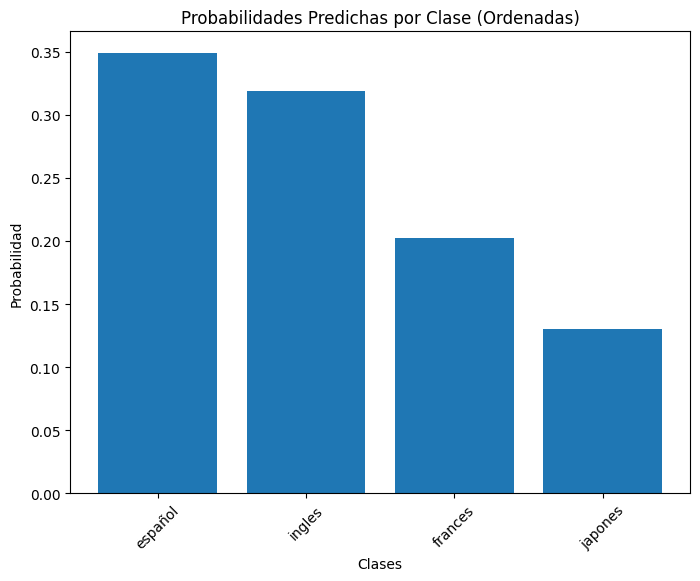

In [16]:
import random
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np

# Seleccionar una clase al azar
random_class = random.choice(classes)
class_dir = os.path.join(data_dir, random_class)

# Seleccionar un audio al azar dentro de la clase seleccionada
random_audio = random.choice(os.listdir(class_dir))
audio_path = os.path.join(class_dir, random_audio)
print(f"Audio aleatorio seleccionado: {audio_path}")

# Reproducir el audio
print("Reproduciendo el audio seleccionado:")
ipd.display(ipd.Audio(audio_path))

# Obtener la predicción del modelo
predicted_class, audio_prediction = predict_audio(model, audio_path, sample_rate, segment_length, segment_stride)

# Obtener el nombre de la clase predicha
predicted_class_name = classes[predicted_class]
print(f"\nPredicción para el audio completo: Clase {predicted_class_name}")

# Mostrar las probabilidades por clase
print("\nProbabilidades por clase:")
for i, class_name in enumerate(classes):
    print(f"{class_name}: {audio_prediction[i]:.4f}")

# Ordenar las probabilidades y las clases
sorted_indices = np.argsort(audio_prediction)[::-1]
sorted_classes = [classes[i] for i in sorted_indices]
sorted_probabilities = audio_prediction[sorted_indices]

# Gráfico de barras de las probabilidades ordenadas
plt.figure(figsize=(8, 6))
plt.bar(sorted_classes, sorted_probabilities)
plt.title('Probabilidades Predichas por Clase (Ordenadas)')
plt.xlabel('Clases')
plt.ylabel('Probabilidad')
plt.xticks(rotation=45)
plt.show()


In [17]:
# Guardar el modelo en formato Keras
model.save('audio_classification_model.keras')


In [18]:
from tensorflow.keras.models import load_model

# Cargar el modelo guardado
model = load_model('audio_classification_model.keras')
